Optimal number of clusters (k): 10
DB Index for optimal k: 0.8079919837103067


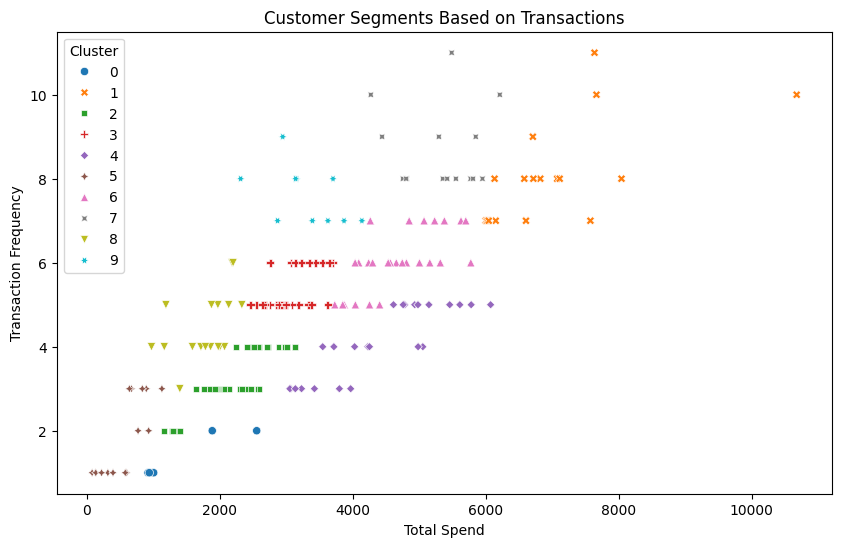

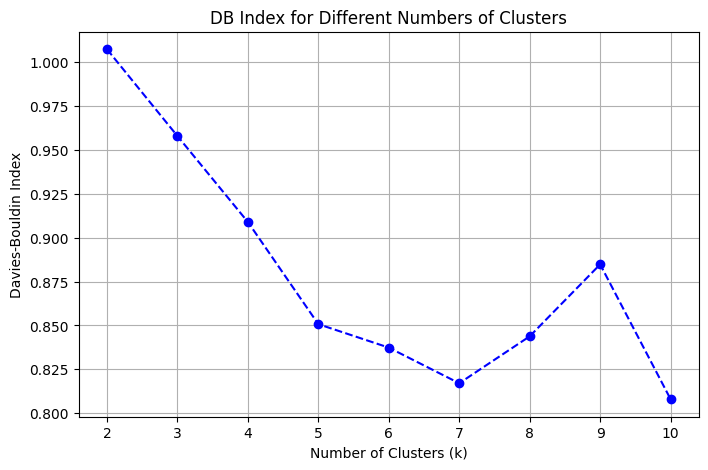

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Preprocess data
# Aggregate transaction data for each customer
customer_transactions = transactions.groupby('CustomerID').agg(
    TotalSpend=('TotalValue', 'sum'),
    TransactionFrequency=('TransactionID', 'count'),
    AvgTransactionValue=('TotalValue', 'mean')
).reset_index()

# Merge with customer profile data
customers['CustomerID'] = customers['CustomerID'].astype(str)
customer_transactions['CustomerID'] = customer_transactions['CustomerID'].astype(str)
customer_data = pd.merge(customers, customer_transactions, on='CustomerID', how='inner')

# Select features for clustering
features = ['TotalSpend', 'TransactionFrequency', 'AvgTransactionValue']
X = customer_data[features]

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform KMeans clustering for k=2 to k=10
db_scores = []
cluster_results = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    db_index = davies_bouldin_score(X_scaled, labels)
    db_scores.append(db_index)
    cluster_results[k] = {
        'model': kmeans,
        'labels': labels,
        'db_index': db_index
    }

# Find the best number of clusters based on the lowest DB Index
best_k = min(cluster_results, key=lambda k: cluster_results[k]['db_index'])
best_model = cluster_results[best_k]['model']
customer_data['Cluster'] = cluster_results[best_k]['labels']

print(f"Optimal number of clusters (k): {best_k}")
print(f"DB Index for optimal k: {cluster_results[best_k]['db_index']}")

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_data['TotalSpend'],
    y=customer_data['TransactionFrequency'],
    hue=customer_data['Cluster'],
    palette='tab10',
    style=customer_data['Cluster']
)
plt.title('Customer Segments Based on Transactions')
plt.xlabel('Total Spend')
plt.ylabel('Transaction Frequency')
plt.legend(title='Cluster')
plt.show()

# Plot DB Index for different k values
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), db_scores, marker='o', linestyle='--', color='b')
plt.title('DB Index for Different Numbers of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.grid()
plt.show()


Other clustering metrics

In [5]:
# Finding Silhouette_score
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(X_scaled, best_model.labels_)
print(f"Silhouette Score: {silhouette_avg:.2f}")


Silhouette Score: 0.36


In [6]:
#  Calinski-Harabasz Index (Variance Ratio Criterion)
from sklearn.metrics import calinski_harabasz_score

calinski_harabasz = calinski_harabasz_score(X_scaled, best_model.labels_)
print(f"Calinski-Harabasz Index: {calinski_harabasz:.2f}")


Calinski-Harabasz Index: 137.83


In [7]:
# Within-Cluster Sum of Squares (WCSS)
wcss = best_model.inertia_
print(f"Within-Cluster Sum of Squares (WCSS): {wcss:.2f}")

Within-Cluster Sum of Squares (WCSS): 78.93
